In [7]:
import torchvision
import numpy as np

In [65]:
transform = transforms.Compose([
    transforms.ToTensor(),])
train_set = datasets.CIFAR100('./CIFAR100', download=True, train=True, transform=transform)
test_set = datasets.CIFAR100('./CIFAR100', download=True, train=False, transform=transform)
select = [3, 88]
train_set.targets = np.array(train_set.targets)
test_set.targets = np.array(test_set.targets)
train_idx = train_set.targets == -1
test_idx = test_set.targets == -1
for item in select:
    train_idx += train_set.targets == item
    test_idx += test_set.targets == item
train_set.targets = train_set.targets[train_idx]
train_set.data = train_set.data[train_idx]
test_set.targets = test_set.targets[test_idx]
test_set.data = test_set.data[test_idx]
for index, item in enumerate(select):
    train_set.targets[train_set.targets == item] = index
    test_set.targets[test_set.targets == item] = index

train_size = len(train_set.targets)
test_size = len(test_set.targets)


Files already downloaded and verified
Files already downloaded and verified


In [66]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, drop_last=True)

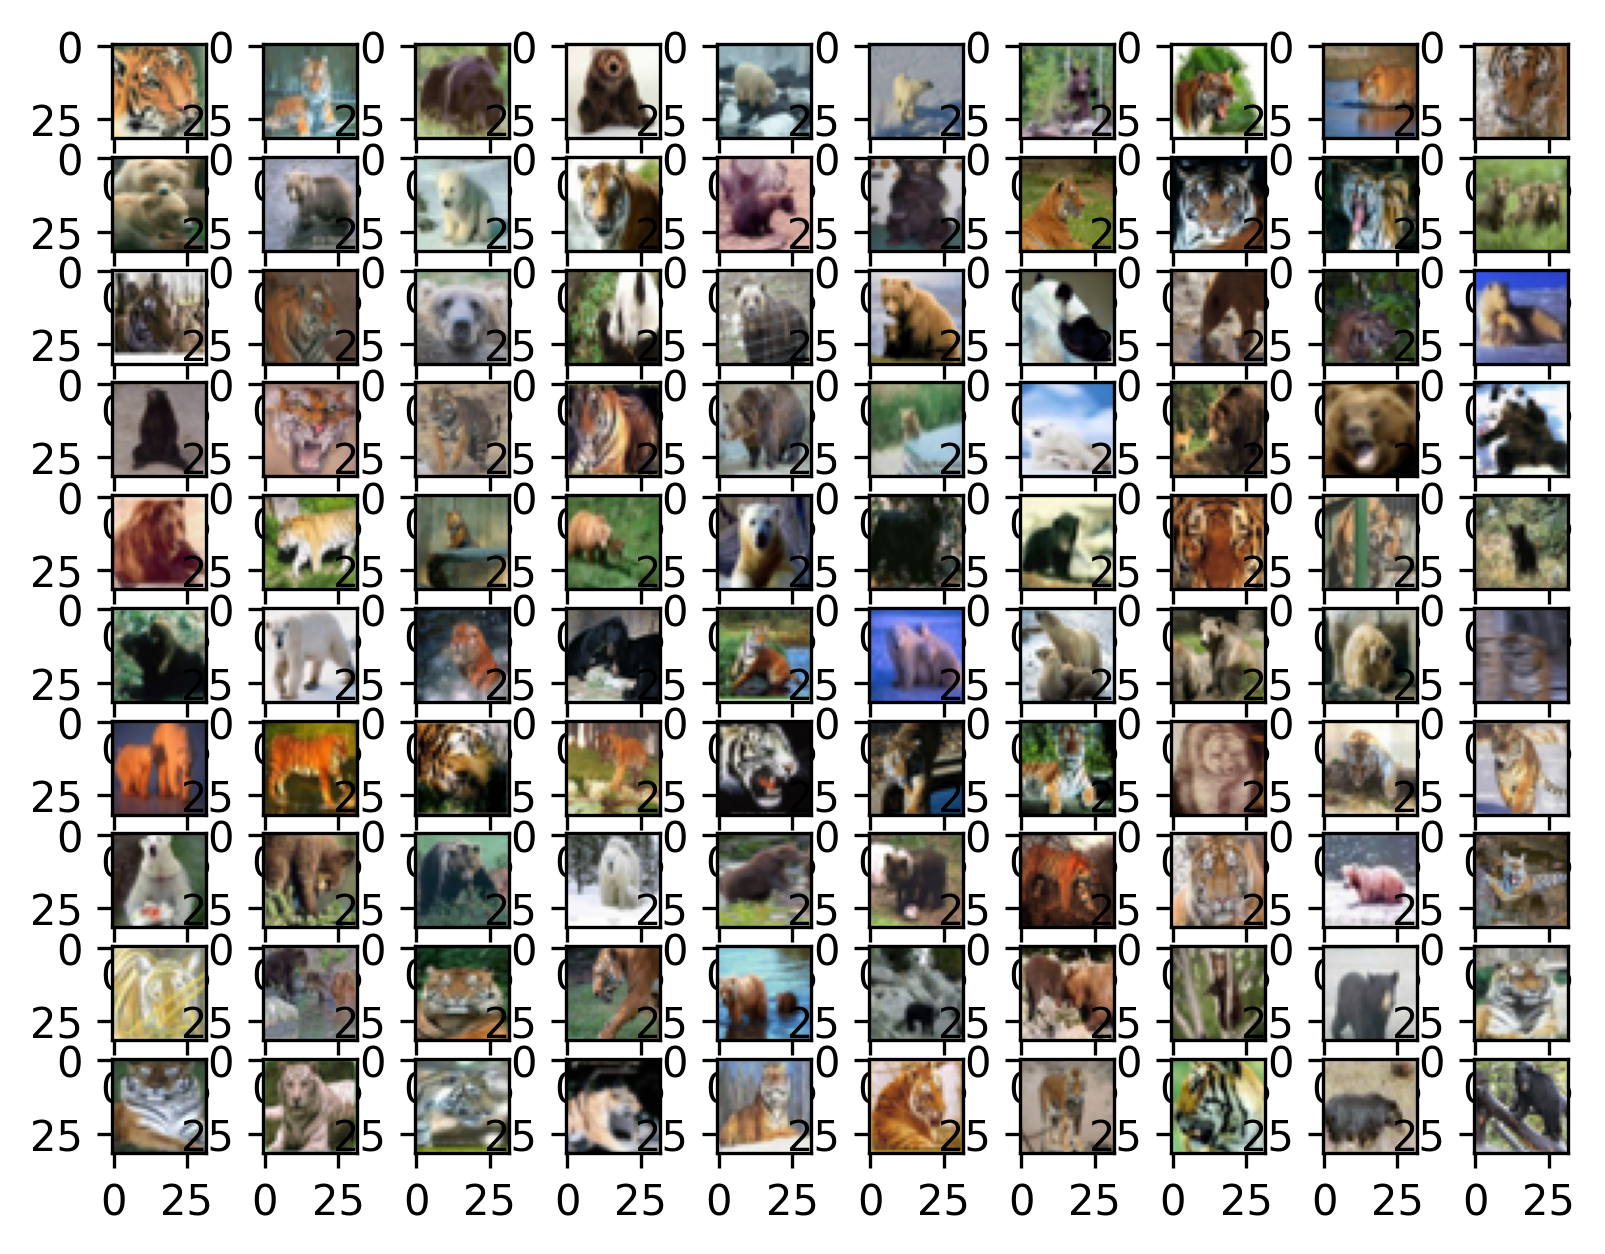

In [68]:
fig, ax = plt.subplots(10, 10, dpi=300)
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(train_set.data[i*10+j])
plt.show()

In [69]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt

In [70]:
n_epochs = 50   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "." # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Quantum pre-processing of train images:
tensor([1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
        1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
torch.Size([64, 3, 32, 32]), 2, 2, 1, 2, 2, 2, 1, 1, 2], dtype=torch.int32)/50        
torch.Size([64, 1, 32, 32, 3])
tensor([1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
        2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2,
torch.Size([64, 3, 32, 32]), 2, 1, 1, 2, 1, 2, 1, 1, 1], dtype=torch.int32)/50        
torch.Size([64, 1, 32, 32, 3])
tensor([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1,
torch.Size([64, 3, 32, 32]), 2, 2, 1, 1, 1, 1, 1, 2, 1], dtype=torch.int32)/50        
torch.Size([64, 1, 32, 32, 3])
tensor([2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2,

NameError: name 'train_images' is not defined

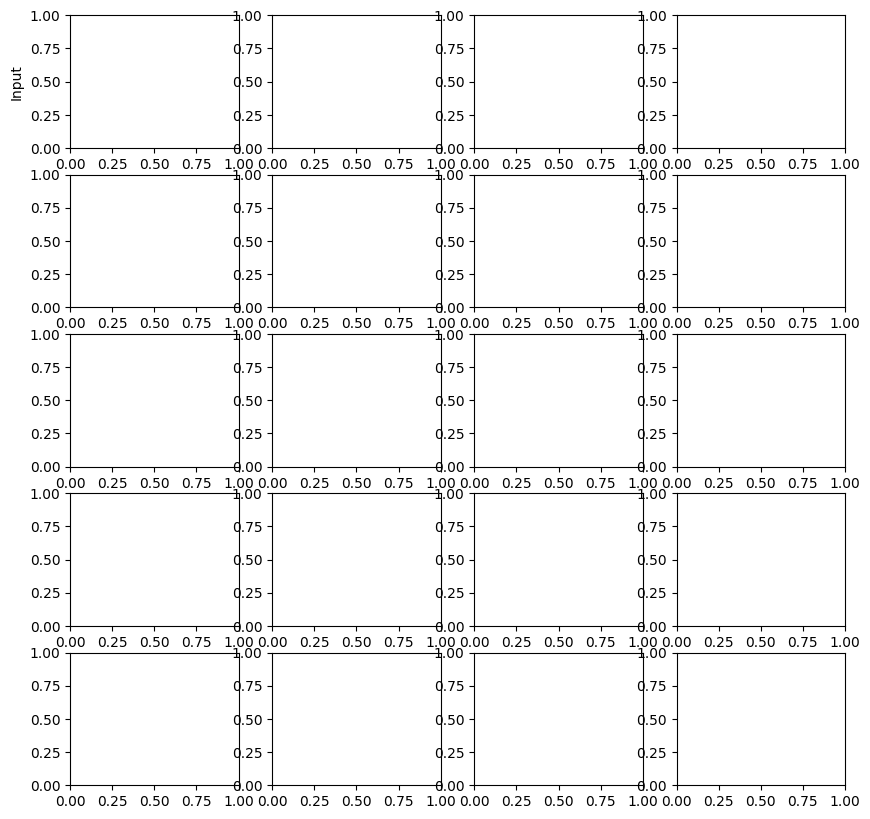

In [80]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((16, 16, 4))
    
    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 32, 2):
        for k in range(0, 32, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            if j + 1 < 32 and k + 1 < 32:
                q_results = circuit([
                    image[0, 0, j, k],
                    image[0, 0, j, k + 1],
                    image[0, 0, j + 1, k],
                    image[0, 0, j + 1, k + 1]
                ])
            # Compute the mean of q_results and assign it to out[j // 2, k // 2, c]
            for c in range(4):
                out[j // 2, k // 2, c] = np.mean(q_results)
    return out


q_train_images = []
print("Quantum pre-processing of train images:")
for img, idx in train_loader:
    print("{}/{}        ".format(idx + 1, n_train), end="\r")
    print(img.shape)
    img = img.permute(0,2,3,1)
    img = img[:, None, :, :, :]
    print(img.shape)
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_test_images = []
print("\nQuantum pre-processing of test images:")
for img, idx in test_loader:
    print("{}/{}        ".format(idx + 1, n_test), end="\r")
    print(img.shape)
    img = img.permute(0,2,3,1)
    img = img[:, None, :, :, :]
    print(img.shape)
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # input channels=3, output channels=64, kernel_size=3
        self.pool = nn.MaxPool2d(2, 2)  # max pooling, kernel_size=2, stride=2
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)  # input channels=64, output channels=64, kernel_size=3
        self.dropout = nn.Dropout2d(p=0.2)  # dropout with probability 0.2
        self.fc1 = nn.Linear(64 * 8 * 8, 10)  # fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # convolution -> ReLU -> max pooling
        x = self.pool(F.relu(self.conv2(x)))  # convolution -> ReLU -> max pooling
        x = self.dropout(x)  # apply dropout
        x = x.view(-1, 64 * 8 * 8)  # flatten the tensor
        x = self.fc1(x)  # fully connected layer
        return x

q_model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(q_model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.long()  # 將目標張量轉換為 LongTensor
        optimizer.zero_grad()
        outputs = q_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # 每 2000 個 mini-batches 印出一次
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

    # 在每個 epoch 結束後，你也可以印出該 epoch 的訓練結果
    print(f"Epoch {epoch + 1} finished. Loss: {running_loss / len(train_loader):.3f}")



Epoch 1 finished. Loss: 0.886
Epoch 2 finished. Loss: 0.572
Epoch 3 finished. Loss: 0.524
Epoch 4 finished. Loss: 0.459
Epoch 5 finished. Loss: 0.427
Epoch 6 finished. Loss: 0.359
Epoch 7 finished. Loss: 0.340
Epoch 8 finished. Loss: 0.336
Epoch 9 finished. Loss: 0.336
Epoch 10 finished. Loss: 0.304
Epoch 11 finished. Loss: 0.288
Epoch 12 finished. Loss: 0.281
Epoch 13 finished. Loss: 0.273
Epoch 14 finished. Loss: 0.280
Epoch 15 finished. Loss: 0.263
Epoch 16 finished. Loss: 0.265
Epoch 17 finished. Loss: 0.252
Epoch 18 finished. Loss: 0.246
Epoch 19 finished. Loss: 0.229
Epoch 20 finished. Loss: 0.216
Epoch 21 finished. Loss: 0.217
Epoch 22 finished. Loss: 0.216
Epoch 23 finished. Loss: 0.213
Epoch 24 finished. Loss: 0.177
Epoch 25 finished. Loss: 0.165
Epoch 26 finished. Loss: 0.198
Epoch 27 finished. Loss: 0.185
Epoch 28 finished. Loss: 0.151
Epoch 29 finished. Loss: 0.158
Epoch 30 finished. Loss: 0.142
Epoch 31 finished. Loss: 0.153
Epoch 32 finished. Loss: 0.153
Epoch 33 finished

In [85]:
correct = 0
total = 0
with torch.no_grad():  # 停用梯度計算
    for data in test_loader:
        inputs, labels = data
        outputs = q_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2%}")


Accuracy of the network on the test images: 85.42%
